In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import defaultdict, Counter
from konlpy.tag import Okt
from datetime import datetime
import os
from wordcloud import WordCloud

In [ ]:
# ───────────── 설정 ─────────────
# rcParams['font.family'] = 'NanumSquare'
rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

DATA_DIR = "../01_데이터수집/data/제20대_대선_테마주/"
PAXNET_PATH = "../01_데이터수집/비정형데이터/faxnet_20/팍스넷_20대_대선_테마주_크롤링_20250627.csv"
NAVER_PATH = "../01_데이터수집/비정형데이터/stock_community/output/csv/제20대_대선_테마주/"
POS_PATH = "../03_모델링/sentiment_dictionary/final_positive_dict.csv"
NEG_PATH = "../03_모델링/sentiment_dictionary/final_negative_dict.csv"

FIXED_START = datetime(2022, 2, 5)
FIXED_END = datetime(2022, 3, 16)

In [21]:
# ───────────── 데이터 로딩 ─────────────

####################### 팍스넷 데이터 ##################################
paxnet_df = pd.read_csv(PAXNET_PATH)
paxnet_df["날짜"] = pd.to_datetime(paxnet_df["날짜"])
#####################################################################



####################### 네이버 종토방 데이터 #############################
csv_files = [f for f in os.listdir(NAVER_PATH) if f.endswith(".csv")]   # 경로 내 csv 파일 목록 가져오기

dataframes = [] # concat 저장용

# 각 CSV 파일 읽어서 리스트에 추가
for file in csv_files:
    file_path = os.path.join(NAVER_PATH, file)
    try:
        df = pd.read_csv(file_path)
        df['filename'] = file  # 어떤 파일에서 왔는지 표시
        dataframes.append(df)
    except Exception as e:
        print(f"파일 읽기 오류: {file_path} → {e}")

naver_df = pd.concat(dataframes, ignore_index=True) # concat
naver_df['article_date'] = pd.to_datetime(naver_df['article_date'])
#####################################################################



###################### 긍정, 부전 사전 #################################
positive_df = pd.read_csv(POS_PATH)
negative_df = pd.read_csv(NEG_PATH)
sentiment_dict = {
    **dict(zip(positive_df["단어"], positive_df["최종점수"])),
    **dict(zip(negative_df["단어"], negative_df["최종점수"]))
}
#####################################################################

okt = Okt()  # 형태소 분석기 인스턴스 생성

In [22]:
naver_df

,stock_name,stock_code,article_date,article_title,article_nickname,article_content,article_comments,article_viewers,article_likes,article_dislikes,article_url,vote_election,vote_candidate,vote_category,vote_start_date,vote_end_date,filename
0,이스타코,15020,2022-03-16,범양 상쳤다. 이놈도 상칠차례,al******,"[특징주] 이스타코, '기본주택' 공급 확대 공약 정책주 부각",[],874,1,1,https://finance.naver.com/item/board_read.nave...,20대,이재명,인맥주,2022-02-05,2022-03-16,stock_articles_20대_이재명_015020_이스타코.csv
1,이스타코,15020,2022-03-16,우와,kysu****,이거 언제 빼야지~~!!,[],535,0,0,https://finance.naver.com/item/board_read.nave...,20대,이재명,인맥주,2022-02-05,2022-03-16,stock_articles_20대_이재명_015020_이스타코.csv
2,이스타코,15020,2022-03-16,아ㅅㅍ,medi****,물탈껄ㅠ 탈출인데 ㅆㅣㄷㅐㅇ,[],559,1,1,https://finance.naver.com/item/board_read.nave...,20대,이재명,인맥주,2022-02-05,2022-03-16,stock_articles_20대_이재명_015020_이스타코.csv
3,이스타코,15020,2022-03-16,"[특징주] 이스타코, '기본주택' 공급 확대 공약 정책주 부각",al******,"[특징주] 이스타코, '기본주택' 공급 확대 공약 정책주 부각 연상가자",[],983,1,1,https://finance.naver.com/item/board_read.nave...,20대,이재명,인맥주,2022-02-05,2022-03-16,stock_articles_20대_이재명_015020_이스타코.csv
4,이스타코,15020,2022-03-16,평단1200,anss****,감사요^^,['저는 1355원이요 ㅜㅜ'],554,0,2,https://finance.naver.com/item/board_read.nave...,20대,이재명,인맥주,2022-02-05,2022-03-16,stock_articles_20대_이재명_015020_이스타코.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22916,덕성,4830,2022-02-05,소고기 법카,kkbb****,남양주시장이분노했다 당시상품권 25000원짜리돌렸다고 징계 그런데 이재명부인은법카로...,[],199,5,2,https://finance.naver.com/item/board_read.nave...,20대,윤석열,인맥주,2022-02-05,2022-03-16,stock_articles_20대_윤석열_004830_덕성.csv
22917,덕성,4830,2022-02-05,배씨가 비서역할은 맘에들게 잘했지. 사모도 잘챙기고,karm****,나같아도 내마누라 잘 챙기는 비서 쓰지. 내 마누라 쌩까는 비서는 짜르지. 그런데 ...,['이건 그냥 배씨 개인의 갑질인건데 배씨와 김여사 동일시하는 프레임을 씌우고있는듯...,296,4,4,https://finance.naver.com/item/board_read.nave...,20대,윤석열,인맥주,2022-02-05,2022-03-16,stock_articles_20대_윤석열_004830_덕성.csv
22918,덕성,4830,2022-02-05,"[삭제된 게시물의 답글]그럼 주가조작, 이력서 위조 건희는 쉴드쳐줄만하고?",karm****,ㅋㅋㅋㅋㅋ,[],282,4,7,https://finance.naver.com/item/board_read.nave...,20대,윤석열,인맥주,2022-02-05,2022-03-16,stock_articles_20대_윤석열_004830_덕성.csv
22919,덕성,4830,2022-02-05,외교를 이런식으로 했다고 치면,knso****,이거 완전히 사기꾼 되는겨. 나라 조지는거지 https://youtube.com/s...,['제2의 아베 탄생이 될것인가? 지지율 60프로로 몰표 나왔음 좋것다 나라 망하게...,255,2,3,https://finance.naver.com/item/board_read.nave...,20대,윤석열,인맥주,2022-02-05,2022-03-16,stock_articles_20대_윤석열_004830_덕성.csv


In [23]:
paxnet_df

,종목명,날짜,시간,제목,댓글수,작성자,조회수,추천수,내용,URL
0,상지건설,2022-02-07,15:38:13,이번주 상한가 한번 쏘시나요??? 형님들 상지 너무 조용한데요..,0,나루랜드,6339,1,형님들 부탁 드립니다..,https://www.paxnet.co.kr/tbbs/view?id=042940&s...
1,덕성,2022-02-07,08:43:07,7일아침 방금 뜬 리얼미터 여론조사,0,김치녀,1082,1,께임 끝,https://www.paxnet.co.kr/tbbs/view?id=004830&s...
2,삼부토건,2022-02-08,11:43:48,김건희,1,쩜빵,438,1,윤썩관련주,https://www.paxnet.co.kr/tbbs/view?id=001470&s...
3,삼부토건,2022-02-08,20:07:08,"합병된 무림페이퍼는 매출3조원,영업이익8천600억원,순이익8천500억원,친환경제품 ...",0,매쌓기투자자,368,0,"합병된 무림페이퍼는 매출3조원,영업이익8천600억원,순이익8천500억원,친환경제품 ...",https://www.paxnet.co.kr/tbbs/view?id=001470&s...
4,삼부토건,2022-02-08,22:52:07,삼부토건축상!9일~1/2차일부축소매도대기가격,0,코레나가,190,0,삼부토건1/2차고점매도가격 : 네이버 카페 (naver.com),https://www.paxnet.co.kr/tbbs/view?id=001470&s...
...,...,...,...,...,...,...,...,...,...,...
122,삼부토건,2022-03-14,10:25:21,윤석영당선자정책 원격진료수혜주 본겨부각 소프트렌!!!,1,jhuok,224,1,상최대향상 코로나세계1위확진 코로나총제적난국윤석열 정책 대장주\nhttps://m...,https://www.paxnet.co.kr/tbbs/view?id=001470&s...
123,삼부토건,2022-03-14,10:32:35,인트로메딕 만지던 넘이 매수한 주식,0,k9동방불패,373,0,보유 작살,https://www.paxnet.co.kr/tbbs/view?id=001470&s...
124,삼부토건,2022-03-14,15:06:08,서울대가뭉쳣다 ㆍ대표ㆍ회장 윤석열동문,0,참조쿤,278,0,250만호건설 도로ㆍ철도 지하화 ㆍ부지조성 ㆍ재개발 재건축 철거 수혜\n우크라이...,https://www.paxnet.co.kr/tbbs/view?id=001470&s...
125,덕성,2022-03-14,09:00:05,덕성우 떡상각,0,haru811,742,0,가격대 ㅠ,https://www.paxnet.co.kr/tbbs/view?id=004830&s...


In [ ]:
# ───────────── 데이터 전처리 ─────────────
naver_selected_df = naver_df[["stock_name", "article_date", "article_title", "article_content"]].copy()
naver_selected_df.rename(columns={
    "stock_name": "종목명",
    "article_date": "날짜",
    "article_title": "제목",
    "article_content": "내용"
}, inplace=True)

paxnet_selected_df = paxnet_df[['종목명', '날짜', '제목', '내용']].copy()

stock_df = pd.concat([naver_selected_df, paxnet_selected_df], ignore_index=True)    # 데이터 병합
stock_df.sort_values(by='날짜', inplace=True)   # datetime 순서로 정렬
stock_df

,종목명,날짜,제목,내용
13312,NE능률,2022-02-05,엄지 아래 누가 눌렀는지 나는 알지...,ㅋㅋㅋ 신라면 댓글공작요원.... ㅋㅋㅋ
13219,NE능률,2022-02-05,옛~다~ 선물,"■오늘 김만배윤석열 아는사이 녹취록 공개! 김만배, 윤석열과 아는사이 입증! “에이..."
13218,NE능률,2022-02-05,"[단독] 故 노무현 ""저와 권양숙은 이재명을 지지합니다"" 與 유튜브 영상 논란",이년은 노무현 마누라만 아녀도 뇌물죄로 벌을 받아야 하는 인간이 똑같은 죄명이 지지...
13217,NE능률,2022-02-05,"[단독] 故 노무현 ""저와 권양숙은 이재명을 지지합니다"" 與 유튜브 영상 논란",https://www.cmcglr.com/news/articleView.html?i...
13216,NE능률,2022-02-05,티비토론 딱까리 있어서 하기 싫데,안철수 서울대 심상정 서울대 윤통령 서울대 저기 어디더라 뭔대? 거기 뭔대..? 기...
...,...,...,...,...
2968,NE능률,2022-03-16,쥐새끼 석방하면?,쥐구멍으로 대한민국 둑이터진다
2969,NE능률,2022-03-16,아직도 인맥주 대장 능률...,탈출 안한 흑우들 있나?? 정책주 안보이나? 정책주도 끝물이보이는데... 인맥주....
14423,덕성,2022-03-16,ㅂㅅ 주는 버려,ㅋ
913,서연,2022-03-16,다른주들 다올라도 이건 주구장착 내리네,넘 내려서 팔지도 못하겠네 이런 OOO 같은회사


In [27]:
# ───────────── 감성 점수 계산 함수 ─────────────
def compute_sentiment_by_date(df, stock_name, sentiment_dict, okt):
    score_by_date = defaultdict(float)
    for _, row in df[df["종목명"] == stock_name].iterrows():
        date = row["날짜"].date()
        text = f"{row['제목']} {row['내용']}"
        words = set(okt.morphs(text))
        score = sum(sentiment_dict[word] for word in words if word in sentiment_dict)
        score_by_date[date] += score
    return score_by_date

In [29]:
# ───────────── 종목별 감성 점수 및 주가 저장 ─────────────
all_stock_sentiment = {}
all_stock_prices = {}

for file_name in os.listdir(DATA_DIR):
    if not file_name.endswith(".csv"):
        continue

    file_path = os.path.join(DATA_DIR, file_name)
    price_df = pd.read_csv(file_path)
    price_df["Date"] = pd.to_datetime(price_df["Date"])
    price_df = price_df[(price_df["Date"] >= FIXED_START) & (price_df["Date"] <= FIXED_END)]

    if price_df.empty:
        continue

    stock_name = price_df["Name"].iloc[0]
    score_by_date = compute_sentiment_by_date(stock_df, stock_name, sentiment_dict, okt)

    sentiment_df = pd.DataFrame({
        "날짜": pd.to_datetime(list(score_by_date.keys())),
        "감성점수": list(score_by_date.values())
    }).sort_values("날짜")

    all_stock_sentiment[stock_name] = sentiment_df
    all_stock_prices[stock_name] = price_df

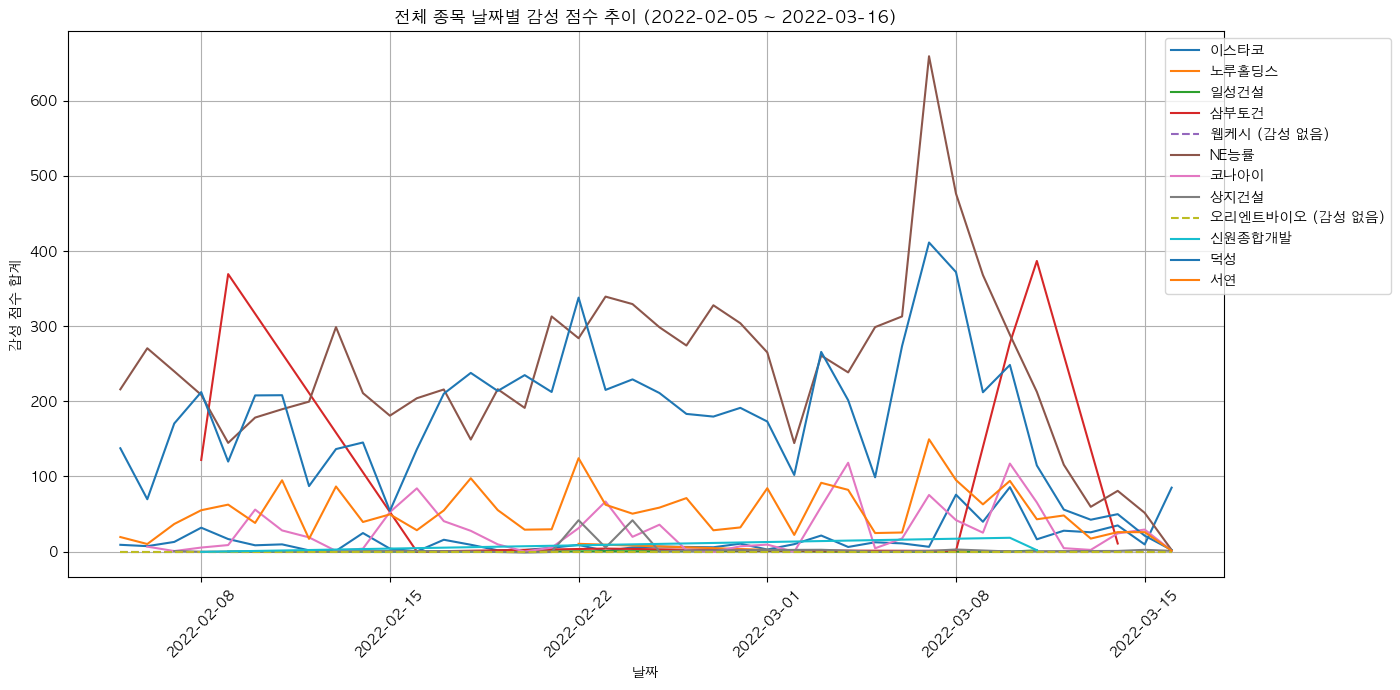

In [30]:
# ───────────── [1] 전체 종목 감성 점수 추이 ─────────────
plt.figure(figsize=(14, 7))

for stock, sentiment_df in all_stock_sentiment.items():
    filtered_sentiment = sentiment_df[
        (sentiment_df["날짜"] >= FIXED_START) &
        (sentiment_df["날짜"] <= FIXED_END)
    ]
    if filtered_sentiment.empty:
        # 날짜 축만 유지하고 y=0 값으로 대체
        plt.plot([FIXED_START, FIXED_END], [0, 0], linestyle='--', label=f"{stock} (감성 없음)")
    else:
        plt.plot(filtered_sentiment["날짜"], filtered_sentiment["감성점수"], label=stock)

plt.title("전체 종목 날짜별 감성 점수 추이 (2022-02-05 ~ 2022-03-16)")
plt.xlabel("날짜")
plt.ylabel("감성 점수 합계")
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1.0))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ───────────── [2] 종목별 감성 점수만 시각화 ─────────────
for stock_name, sentiment_df in all_stock_sentiment.items():
    filtered_sentiment = sentiment_df[
        (sentiment_df["날짜"] >= FIXED_START) &
        (sentiment_df["날짜"] <= FIXED_END)
    ]

    plt.figure(figsize=(10, 4))
    if filtered_sentiment.empty:
        plt.plot([FIXED_START, FIXED_END], [0, 0], linestyle='--', color='gray')
        plt.title(f"{stock_name}: 감성 점수 없음 (2022-02-05 ~ 2022-03-16)")
    else:
        plt.plot(filtered_sentiment["날짜"], filtered_sentiment["감성점수"],
                 marker='o', color='tab:red')
        plt.title(f"{stock_name}: 날짜별 감성 점수 추이 (2022-02-05 ~ 2022-03-16)")
    plt.xlabel("날짜")
    plt.ylabel("감성 점수")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_4255/2845004644.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[12.8565 31.8011 16.6834  8.3776  9.5943 24.6658  3.903   0.1367 15.733
  9.103   5.0263  8.9371  0.7511  5.568   6.7511 10.5023  9.8734 21.3646
  6.1559  6.3653 75.7191 85.77   16.3323 34.8206  9.5165 85.0931]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


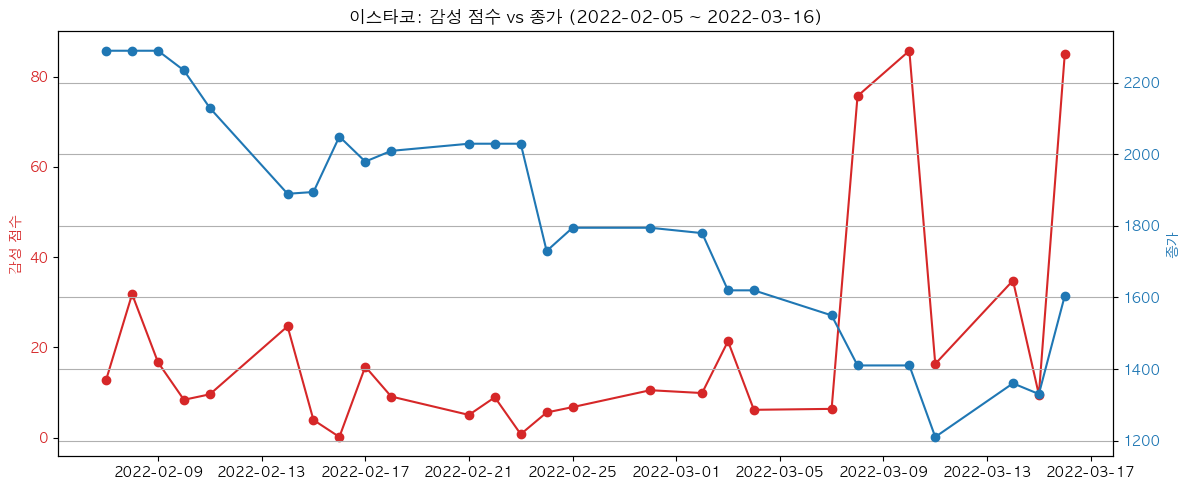

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_4255/2845004644.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[10.3239  0.      0.404 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


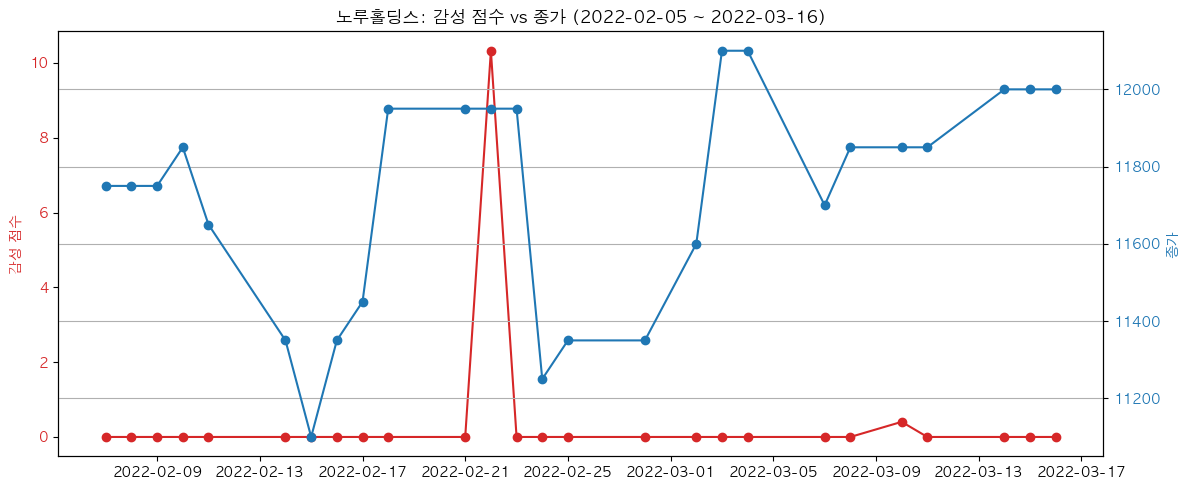

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_4255/2845004644.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.     0.1754 0.7714 0.     0.     1.613 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


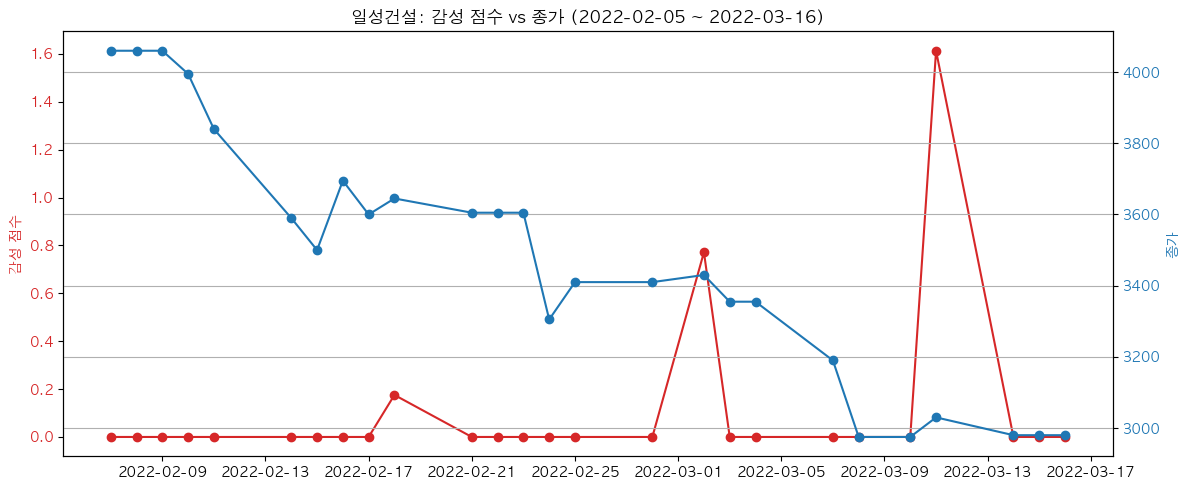

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_4255/2845004644.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[121.9597 369.3356   0.       3.9931   1.5585   1.0373   0.9994 277.5956
 386.8555  10.7533]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


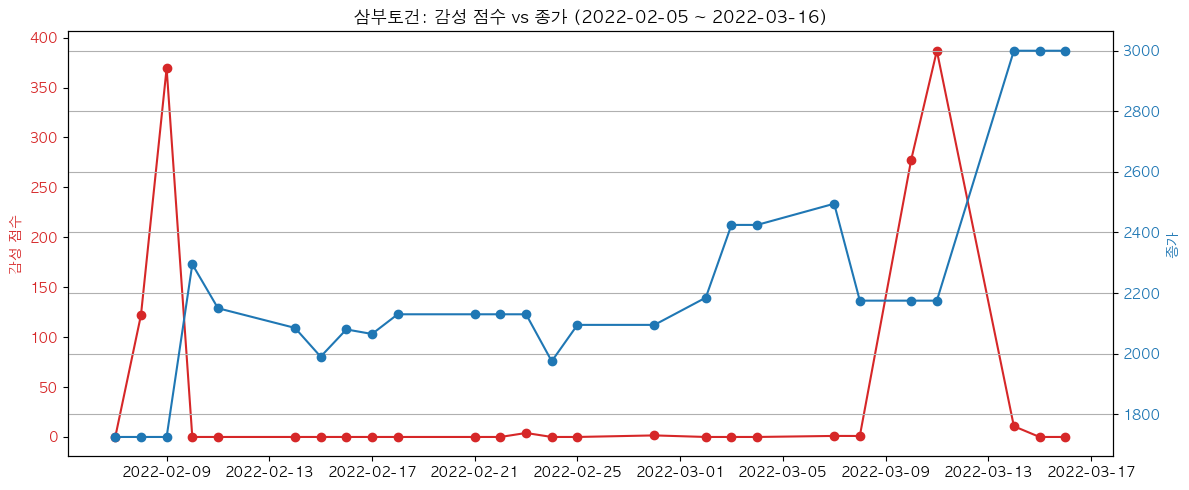

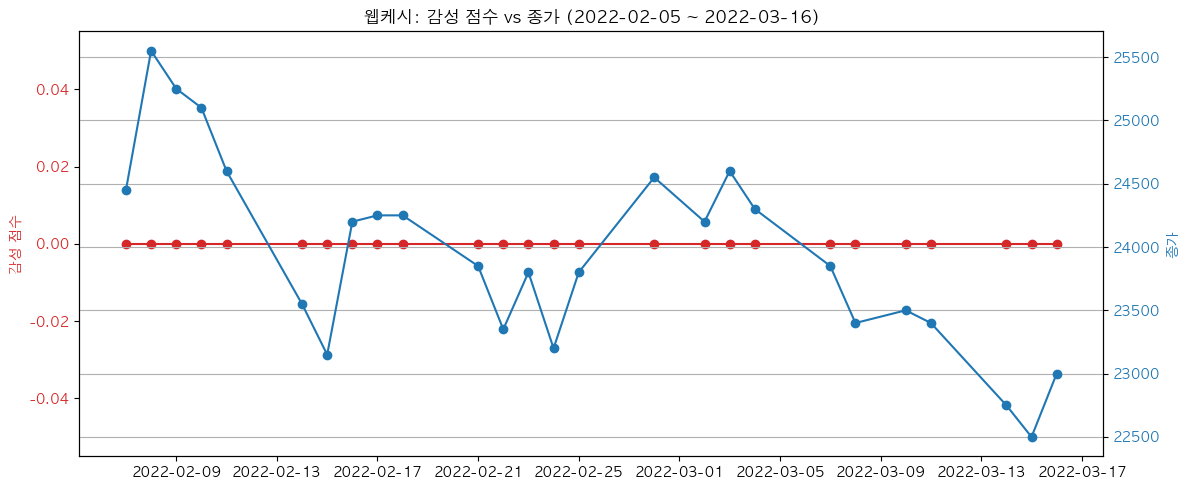

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_4255/2845004644.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[239.8749 208.6531 144.6705 178.3543 189.4768 210.9181 180.9081 204.1104
 215.7753 149.1409 312.9926 283.9769 339.385  329.4328 298.5801 303.9576
 144.4128 260.8838 238.5012 659.3311 476.4891 288.6229 212.6527  80.8533
  51.5836   2.0554]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


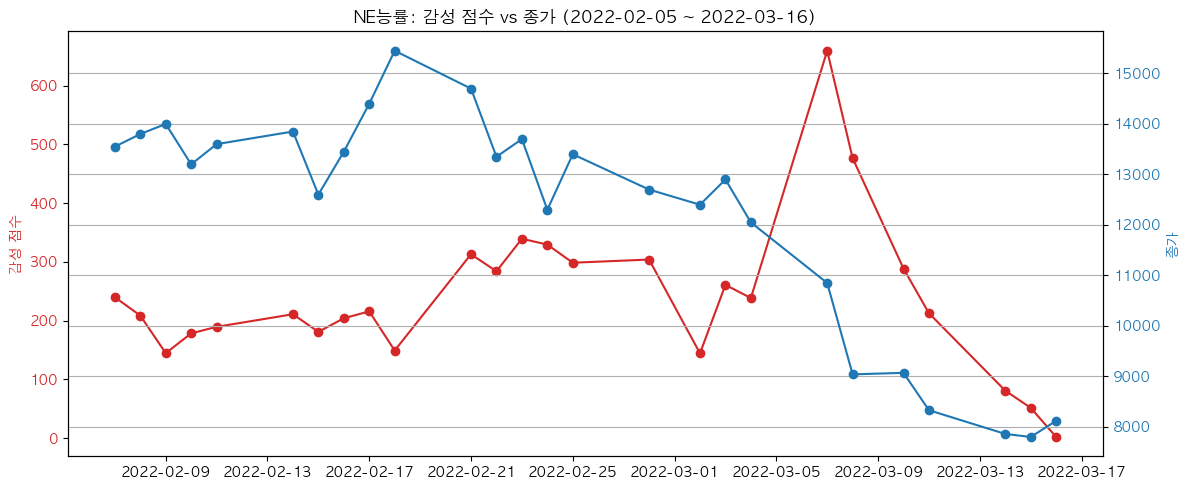

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_4255/2845004644.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  0.6892   5.3692   8.6833  55.8854  28.155    3.9207  52.5788  84.1488
  40.5154  27.6404   5.2434  31.169   66.6509  19.6413  35.7787   7.0394
  -0.3071  59.7055 118.2166  75.3459  41.9013 117.1372  65.3631  24.194
  29.314    1.3207]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


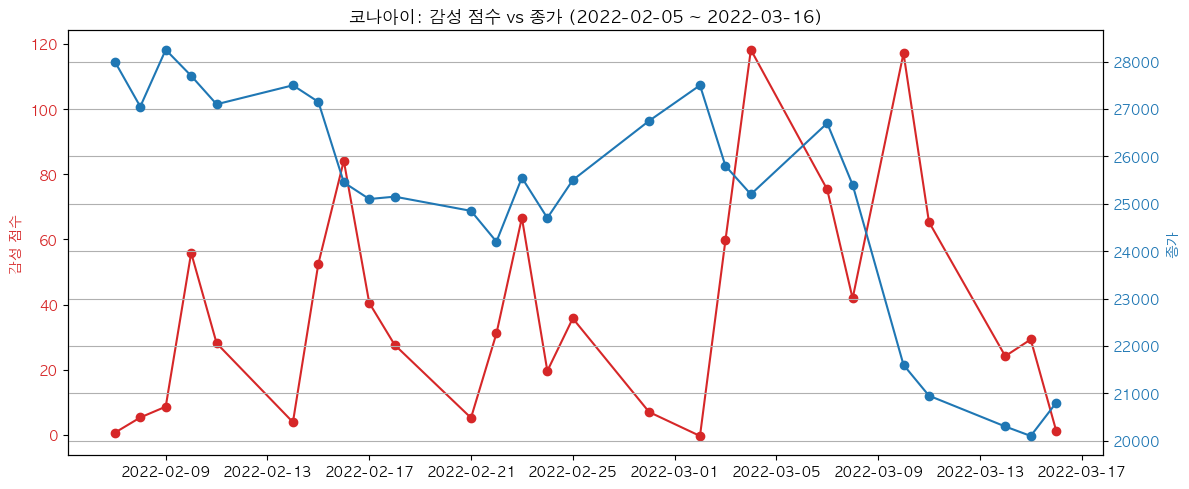

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_4255/2845004644.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.7585 -0.18    0.0797  0.      0.8     0.2052 -0.5519 41.7276  5.4112
 41.6443  0.1896  2.4037  1.2387  0.8194  2.7923  0.1354  0.4905  0.8645
  2.3535  0.9477]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


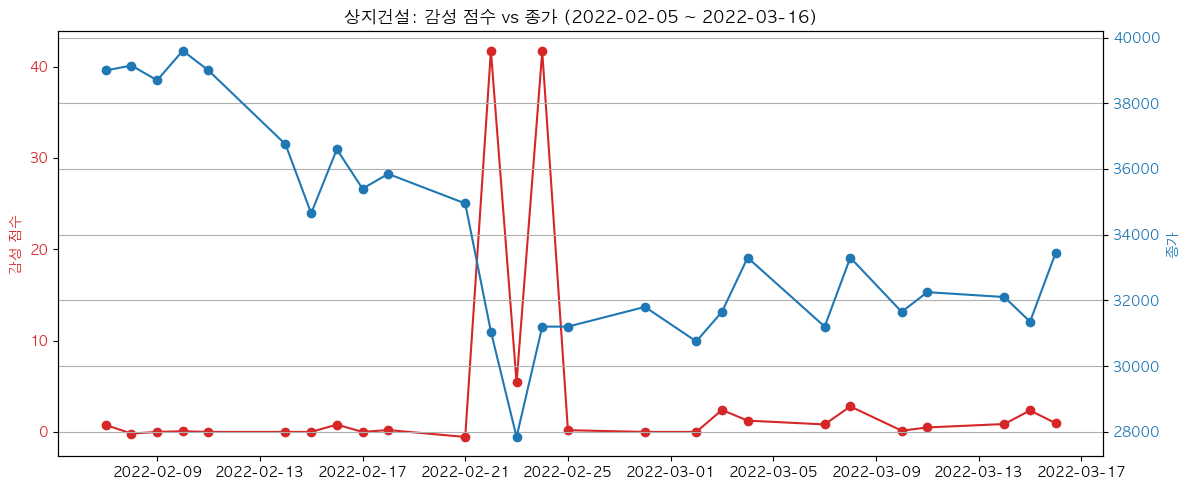

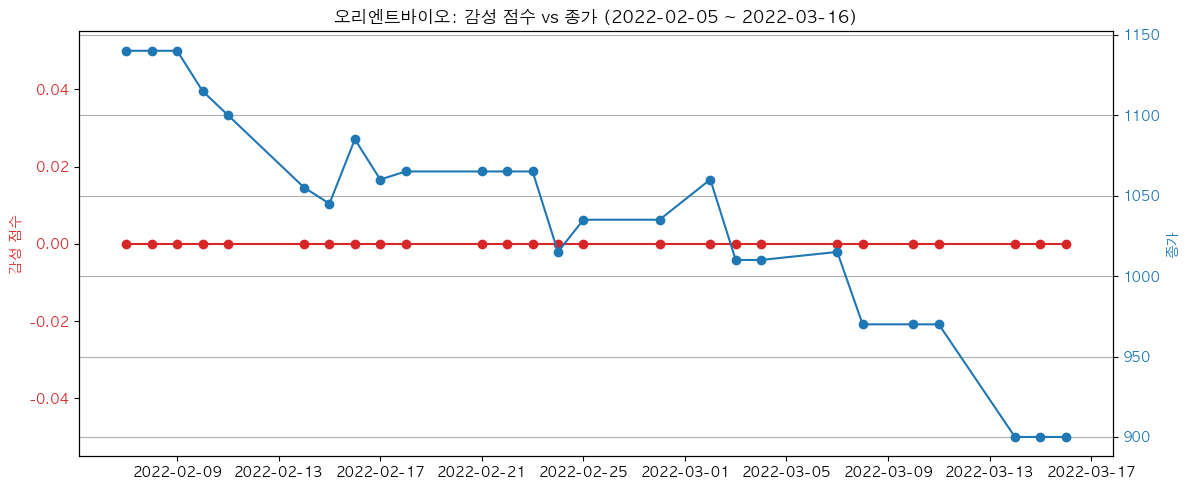

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_4255/2845004644.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.42   18.3778  1.8326]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


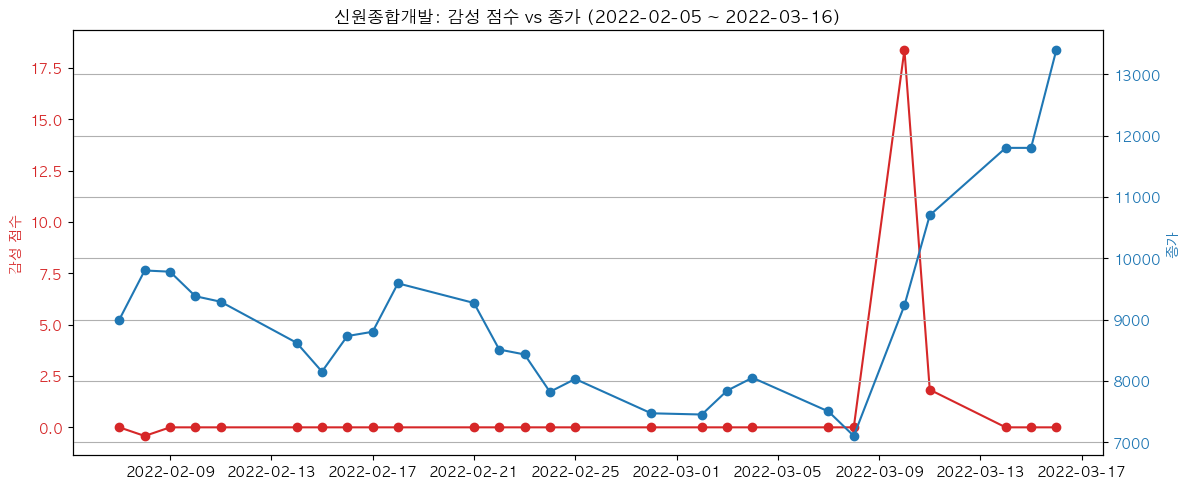

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_4255/2845004644.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[170.5    212.2918 119.8123 207.8769 208.1432 145.2126  54.1436 136.1278
 210.1771 237.8359 212.4296 338.028  215.2121 229.2138 211.051  191.3209
 101.9899 265.7684 201.4932 411.4029 372.0208 248.4277 114.6392  49.8194
  21.1763   2.1318]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


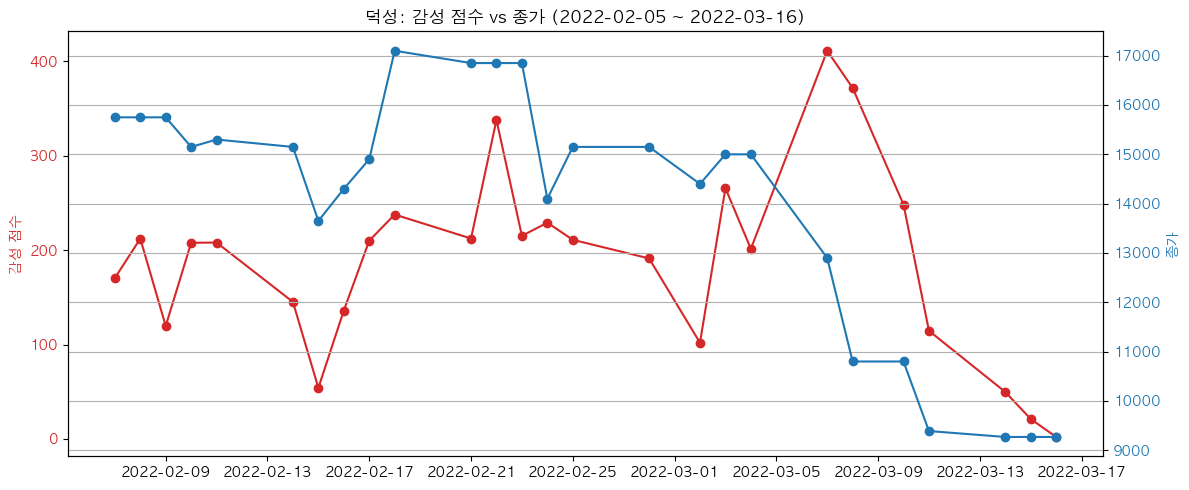

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_4255/2845004644.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 36.7389  55.0433  62.4966  38.1478  94.9183  39.3923  49.5299  28.4404
  54.7919  97.617   29.6527 124.2774  62.3095  50.4573  58.5334  32.1622
  22.1895  91.548   82.1596 149.467   95.1948  94.1228  43.0139  25.9184
  25.8263   1.3471]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])


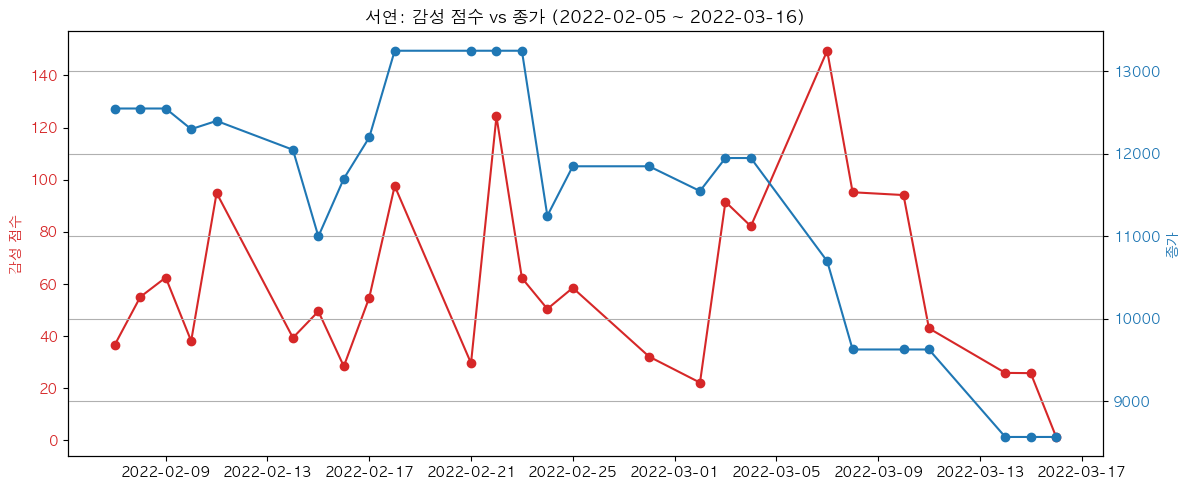

In [32]:
# ───────────── [3] 감성 점수 + 종가 시각화 ─────────────
for stock_name in all_stock_prices:
    price_df = all_stock_prices[stock_name]
    sentiment_df = all_stock_sentiment.get(stock_name, pd.DataFrame())

    fig, ax1 = plt.subplots(figsize=(12, 5))

    # 감성 점수 시각화 (종가 날짜 기준으로 맞춤)
    filtered_sentiment = sentiment_df[
        (sentiment_df["날짜"] >= FIXED_START) & 
        (sentiment_df["날짜"] <= FIXED_END)
    ]
    base_dates = price_df["Date"]

    # 종가 기준 날짜에 맞춘 감성 점수 매핑 (없으면 0)
    sentiment_series = pd.Series(0, index=base_dates)
    sentiment_series.update(filtered_sentiment.set_index("날짜")["감성점수"])

    # 감성 점수 그래프
    ax1.plot(base_dates, sentiment_series.values, 
             color='tab:red', marker='o', linestyle='-', label="감성 점수")
    ax1.set_ylabel("감성 점수", color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # 종가 그래프
    ax2 = ax1.twinx()
    ax2.plot(price_df["Date"], price_df["Close"],
             color='tab:blue', marker='o', linestyle='-', label="종가")
    ax2.set_ylabel("종가", color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # 제목 및 기타 설정
    plt.title(f"{stock_name}: 감성 점수 vs 종가 (2022-02-05 ~ 2022-03-16)")
    fig.tight_layout()
    plt.grid(True)
    plt.show()

In [95]:
# 총 기간은 2022-02-05 ~ 2022-03-16
# 포바이포(이재명 후보 테마주) 출력이 없음
# 확인해보니 종가 데이터 자체가 2022-04-26일부터 시작
# 따라서, 2022-02-05 ~ 2022-03-16 데이터 출력이 불가능함

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_22030/1682697835.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_finance_data["labels"] = df_finance_data["labels"].replace({"neutral": 0, "positive": 1, "negative": 2})


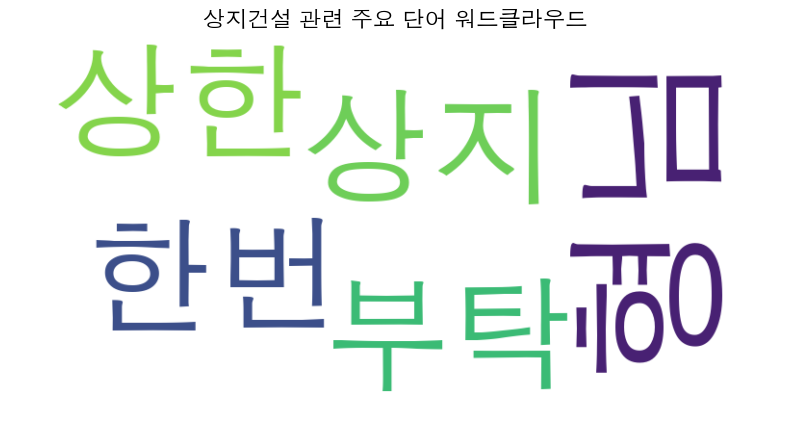

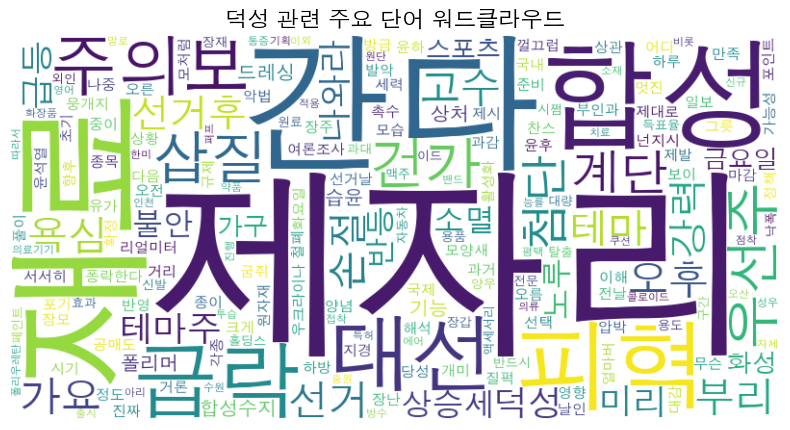

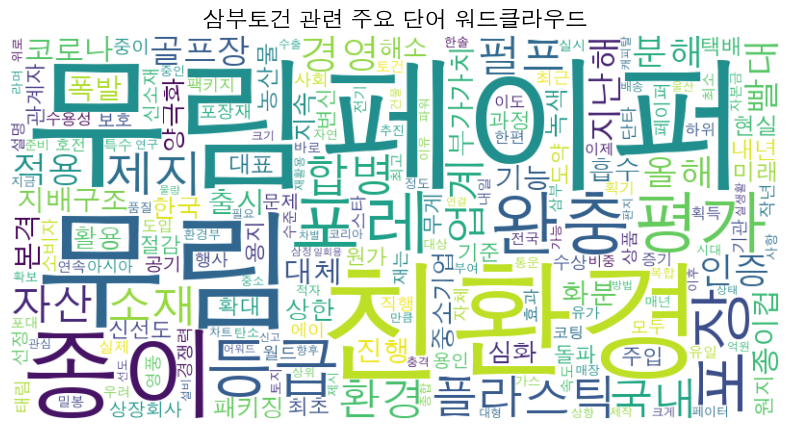

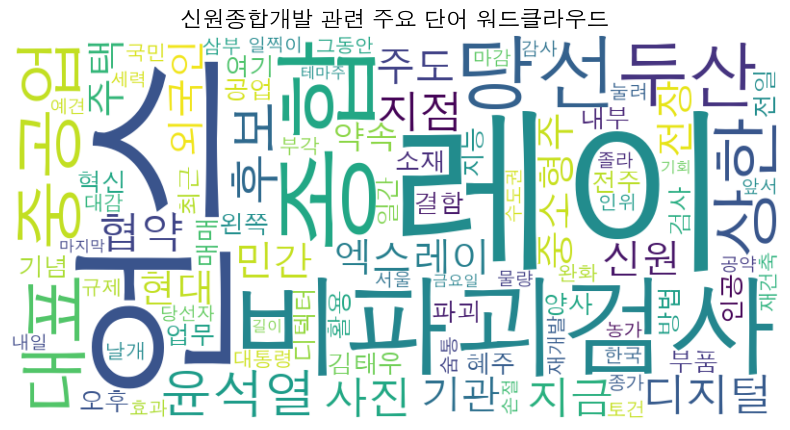

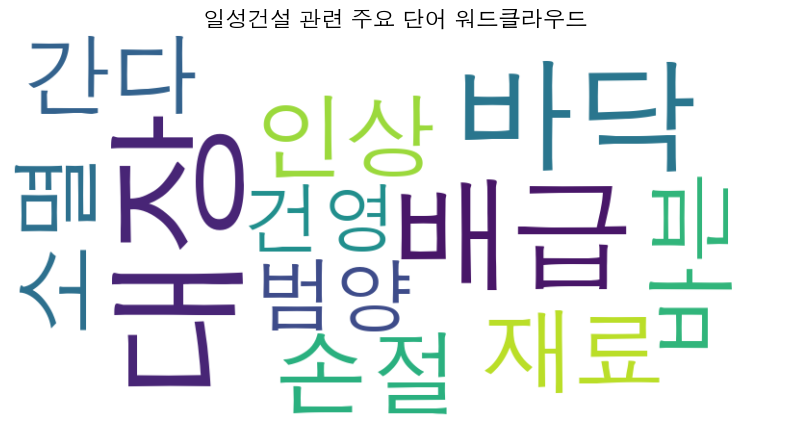

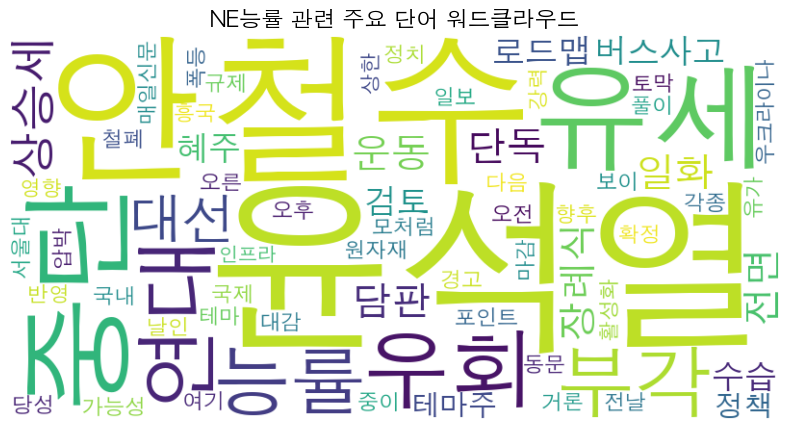

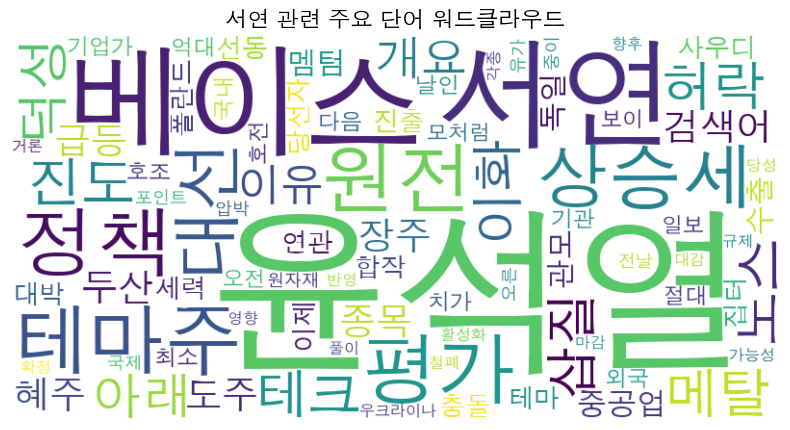

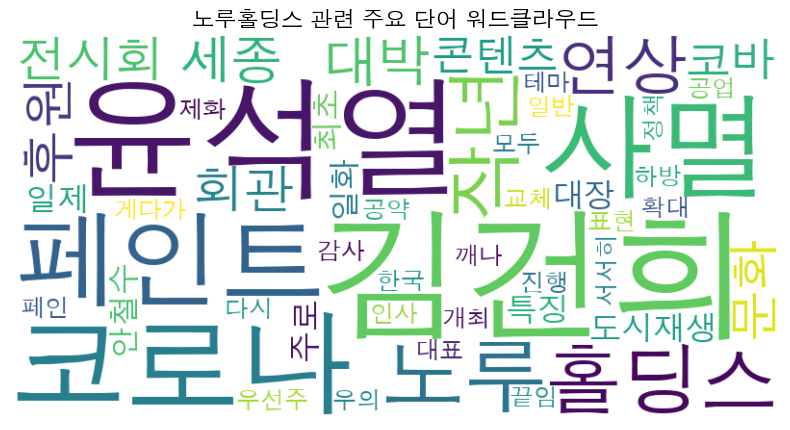

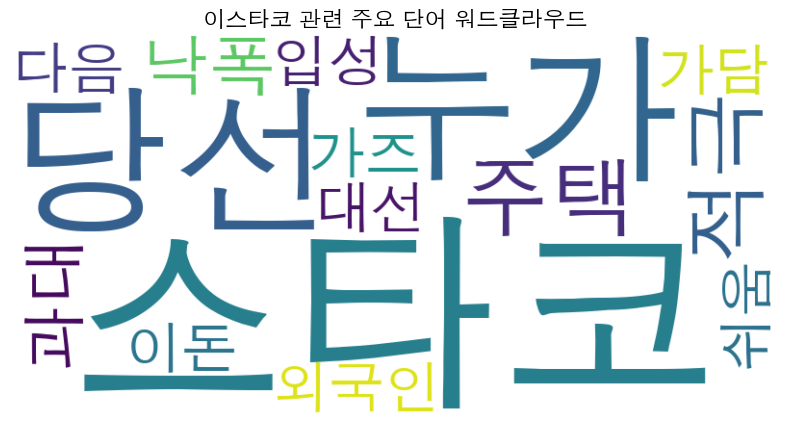

In [97]:
# 데이터 로드
df_finance_data = pd.read_csv("../01_데이터수집/data/finance_data.csv").drop_duplicates(subset=["kor_sentence"])
df_finance_data["labels"] = df_finance_data["labels"].replace({"neutral": 0, "positive": 1, "negative": 2})
texts = df_finance_data["kor_sentence"].tolist()

okt = Okt()

# 불용어 후보 생성 (상위 3% 빈도 단어 + 금융 특화)
all_words = []
for text in texts:
    tokens = okt.pos(text, stem=True)
    all_words.extend([w for w, pos in tokens if pos in ['Noun', 'Adjective', 'Verb'] and len(w) > 1])

counter = Counter(all_words)
top_k = int(len(counter) * 0.03)
high_freq_stopwords = set([w for w, _ in counter.most_common(top_k)])

# 금융 특화 불용어
financial_stopwords = {
    "시장", "주가", "증시", "투자", "매수", "매도", "주식", "증권", 
    "코스피", "코스닥", "기업", "경제", "금융", "지수", "수익", 
    "매출", "실적", "전망", "환율", "금리", "거래", "포트폴리오"
}

# 전체 불용어 세트
candidate_stopwords = high_freq_stopwords | financial_stopwords

def generate_wordcloud(df, stock_name, okt, candidate_stopwords):
    text_corpus = ""
    # 해당 종목의 게시글만 추출
    for _, row in df[df["종목명"] == stock_name].iterrows():
        text = f"{row['제목']} {row['내용']}"
        text_corpus += f" {text}"

    # 형태소 분석 (명사 추출)
    nouns = okt.nouns(text_corpus)
    # 불용어 제거
    filtered = [word for word in nouns if word not in candidate_stopwords and len(word) > 1]

    # 빈도 계산
    word_counts = Counter(filtered)
    if not word_counts:
        print(f"'{stock_name}'에 대해 충분한 텍스트가 없어 워드클라우드를 생성할 수 없습니다.")
        return

    # 워드클라우드 생성
    wc = WordCloud(
        font_path="/System/Library/Fonts/AppleGothic.ttf",  # macOS
        width=800, height=400,
        background_color="white"
    )
    wc.generate_from_frequencies(word_counts)

    # 시각화
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{stock_name} 관련 주요 단어 워드클라우드", fontsize=16)
    plt.show()

# 전체 종목에 대해 반복 수행
for stock_name in df["종목명"].unique():
    generate_wordcloud(df, stock_name, okt, candidate_stopwords)